In [44]:
import time
import os

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tnrange, tqdm_notebook
from __future__ import print_function

import chipwhisperer as cw
from chipwhisperer.tests.tools_for_tests import FIRMWARE_DIR
from chipwhisperer.capture.api.programmers import XMEGAProgrammer
from chipwhisperer.capture.auxiliary.ResetCW1173Read import ResetCW1173
firmware_dir = os.path.abspath(os.path.join(FIRMWARE_DIR, 'simple_pass_cpa'))
hex_file = os.path.join(firmware_dir, r'simple_pass_cpa-CW303.hex')

In [45]:
# Notebook settings
%matplotlib notebook

In [46]:
#%%bash -s "$firmware_dir"
#cd "$1"
#make PLATFORM=CW303

In [47]:
scope = cw.scope()
target = cw.target(scope)

In [48]:
programmer = XMEGAProgrammer()
programmer.scope = scope
programmer._logging = None
programmer.find()
programmer.erase()
programmer.program(hex_file, memtype="flash", verify=True)
programmer.close()

XMEGA Programming flash...
XMEGA Reading flash...
Verified flash OK, 3195 bytes


In [49]:
scope.gain.gain = 45
scope.gain.mode = 'low'
scope.adc.samples = 700
scope.adc.offset = 0
scope.adc.basic_mode = "rising_edge"
scope.adc.timeout = 5
scope.clock.clkgen_freq = 7370000
scope.clock.adc_src = "clkgen_x4"
scope.trigger.triggers = "tio4"
scope.io.tio1 = "serial_rx"
scope.io.tio2 = "serial_tx"
scope.io.hs2 = "clkgen"
delay_ms = 1
Resetter = ResetCW1173(pin='pdic', delay_ms=delay_ms)

In [50]:
def plot(x):
    plt.figure()
    for i in x:
        plt.plot(i)
    plt.show()
def runone(x,y):
    Resetter.reset(scope)
    scope.arm()
    target.getConnection().hardware_write(x)
    target.getConnection().hardware_write(y)
    timeout = 50
    while target.isDone() is False and timeout > 0:
        timeout -= 1
        time.sleep(0.01)
    scope.capture()
    return scope.getLastTrace()
def getbit(b,i):
    if((ord(b)&(1<<i))!=0):
        return 1
    else:
        return 0
def flipbit(s,byte,bit):
    return s[:byte]+chr(ord(s[byte])^(1<<bit))+s[byte+1:]
def hexdump(x):
    return ":".join("{:02x}".format(ord(c)) for c in x)
def getexpected(byte,bit):
    v = b'verysafe'
    return getbit(v[byte],bit)
HW = [bin(n).count("1") for n in range(0,256)]
def HD(a,b):
    return HW[a^b]
def gettraces(trcs,inps,pfix='',n=100):
    for i in tnrange(n, desc='Getting traces'):
        x = pfix+os.urandom(8-len(pfix))
        trcs.append(runone(secr,x))
        inps.append(x)

<IPython.core.display.Javascript object>


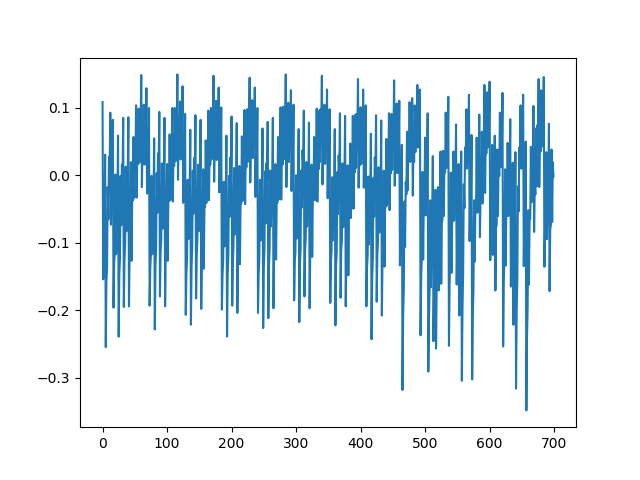

In [51]:
plot((runone(b'aaaaaaaa',b'aaaaaaaa'),))

In [52]:
secr='feedcafe'
trcs=[]
inps=[]
gettraces(trcs,inps,'',200)

SEJveChjaGlsZHJlbj0oSW50UHJvZ3Jlc3ModmFsdWU9MCwgZGVzY3JpcHRpb249dSdHZXR0aW5nIHRyYWNlcycsIG1heD0yMDAsIHN0eWxlPVByb2dyZXNzU3R5bGUoZGVzY3JpcHRpb25fd2nigKY=


In [53]:
def getiteration(x,i):
    start  = 8
    length = 56
    offs   = 56
    return x[start+i*offs:start+i*offs+length]
def corrxor(byte):
    ntrc = len(trcs)
    ltrc = len(trcs[0])
    rs   = []
    for off in range(ltrc):
        a = []
        b = []
        for i in range(ntrc):
            v  = ord(inps[i][byte])
            v ^= ord(secr[byte])
            a.append(HW[v])
            b.append(trcs[i][off])
        rs.append(np.corrcoef(a,b)[1,0])
    return rs
def corrxor_it(byte):
    ntrc = len(trcs)
    ltrc = len(getiteration(trcs[0],0))
    rs   = []
    for off in range(ltrc):
        a = []
        b = []
        for i in range(ntrc):
            v  = ord(inps[i][byte])
            v ^= ord(secr[byte])
            a.append(HW[v])
            b.append(getiteration(trcs[i],byte)[off])
        rs.append(np.corrcoef(a,b)[1,0])
    return rs

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


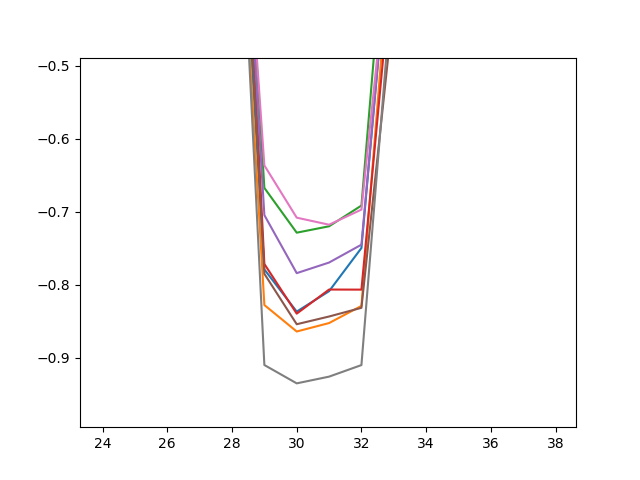

In [55]:
cx = []
for byte in range(8):
    cx.append(corrxor(byte))
plot(cx)

ix = []
for byte in range(8):
    ix.append(corrxor_it(byte))
plot(ix)

In [13]:
pos = []
for c in cx:
    m = min(c)
    p = 0
    for i in range(len(c)):
        if c[i] == m:
            print("pos=%d"%(i))
            pos.append(i)
for i in range(7):
    print("dif=%d"%(pos[i+1]-pos[i]))

pos=38
pos=94
pos=150
pos=206
pos=263
pos=318
pos=425
pos=430
dif=56
dif=56
dif=56
dif=57
dif=55
dif=107
dif=5


In [11]:
# cleanup the connection to the target and scope
scope.dis()
target.dis()